# Model insights

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import mlflow

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)

## Config

In [2]:
# file paths
INPUT_DIR = Path("../input")

OUTPUT_DIR = Path("../output")

# data
TRAIN_DATA = INPUT_DIR / "train.csv"

# columns in the data
INDEX_COL = "Transaction_ID"

TARGET_COL = "MERCHANT_CATEGORIZED_AS"

DATETIME_COLS = ["MERCHANT_CATEGORIZED_AT", "PURCHASED_AT"]

# random seed
RANDOM_SEED = 98765

# MLflow config
MLFLOW_TRACKING_URI = f"sqlite:///{OUTPUT_DIR}/mlruns.db"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

## Extracting model insights

In [3]:
try:
    from src import utils
except ImportError:
    import sys

    !{sys.executable} -m pip install -e .. -q

In [4]:
# helper functions
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import StratifiedKFold
import eli5
import shap


def get_col_names(pipe) -> list:
    """Get the feature names of the transformed matrix"""
    transformers = pipe.named_steps["columntransformer"].named_transformers_
    merchant_cols = list(transformers["merch_name_vec"].get_feature_names_out())
    ts_features = ("month", "day", "weekday", "hour")
    ts_cols = [f"purchased_{feat}" for feat in ts_features]
    untranformed_cols = ["IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY", "USER_HOUSEHOLD"]
    other_cols = ["log_purchase", "log_income", "USER_ID", "USER_GENDER", "age"]
    return merchant_cols + ts_cols + untranformed_cols + other_cols


def explain_models(run_id: str, method="permutation_importance") -> None:
    # load models
    estimators = utils.load_models(run_id)

    # load data
    train_df = pd.read_csv(TRAIN_DATA, index_col=INDEX_COL, parse_dates=DATETIME_COLS)
    y = train_df[TARGET_COL]
    X = train_df.drop(TARGET_COL, axis=1)

    # get cross validation splits
    cv = StratifiedKFold(
        n_splits=len(estimators), shuffle=True, random_state=RANDOM_SEED
    )

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # obtain validation data for a particular fold
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        # transform validation data
        transformer = estimators[fold].named_steps["columntransformer"]
        X_val_trans = transformer.transform(X_val)

        # get the model and feature names
        model = estimators[fold].steps[1][1]
        feature_names = get_col_names(estimators[fold])

        if method == "permutation_importance":
            # obtain permutation importance
            perm = PermutationImportance(model, random_state=RANDOM_SEED)
            perm.fit(X_val_trans, y_val)
            display(eli5.show_weights(perm, feature_names=feature_names))
        elif method == "shap":
            # obtain SHAP values
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_val_trans)
            shap.summary_plot(
                shap_values,
                features=X_val_trans,
                feature_names=feature_names,
                class_names=model.classes_,
            )
        else:
            raise ValueError(f"Unsupported method: {method!r}")

/home/harison/anaconda3/envs/alvin-smcc/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


The least populated class in y has only 2 members, which is less than n_splits=5.


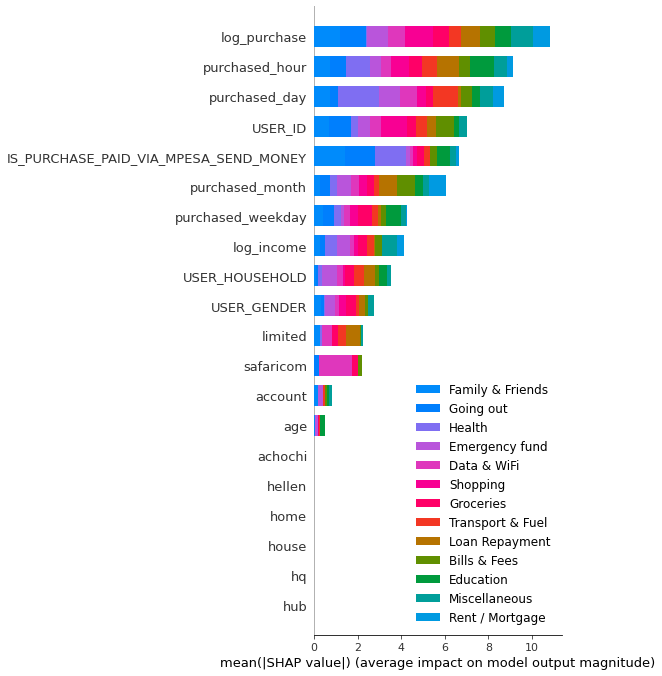

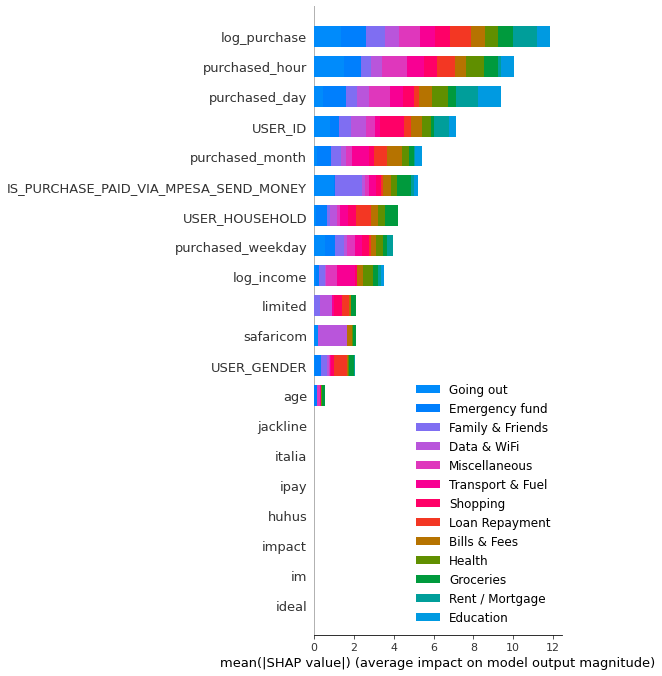

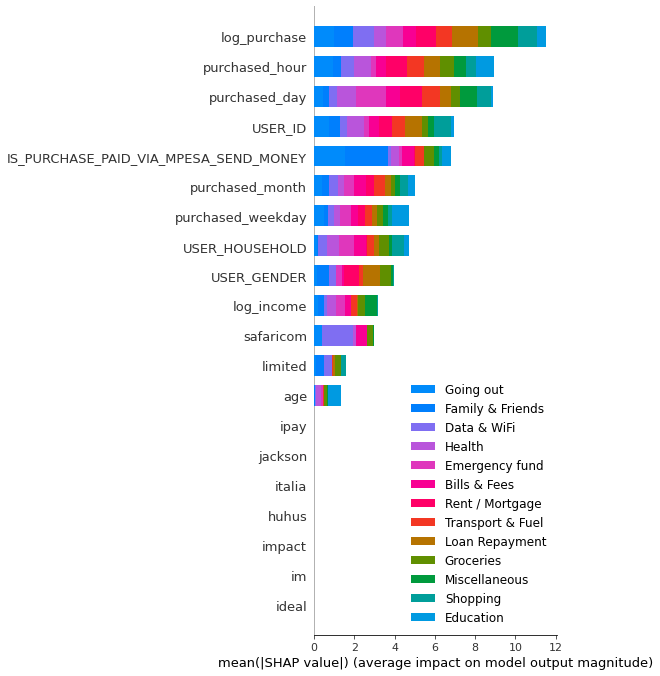

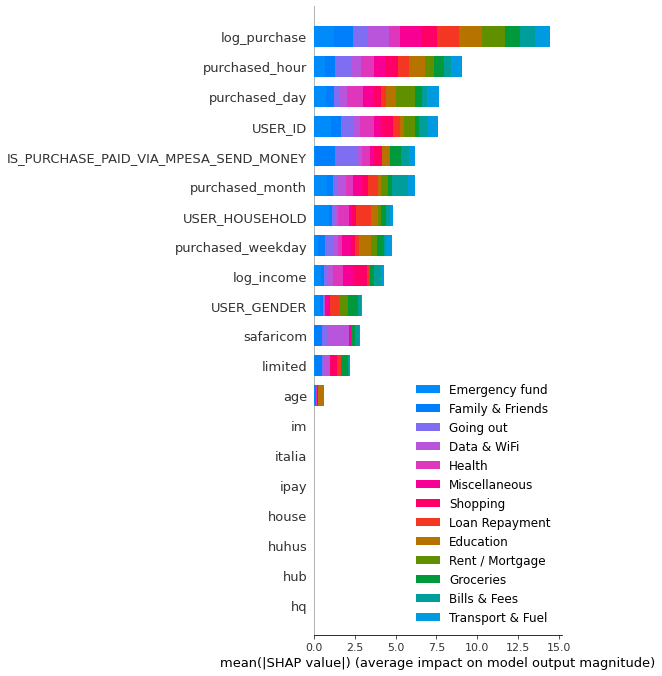

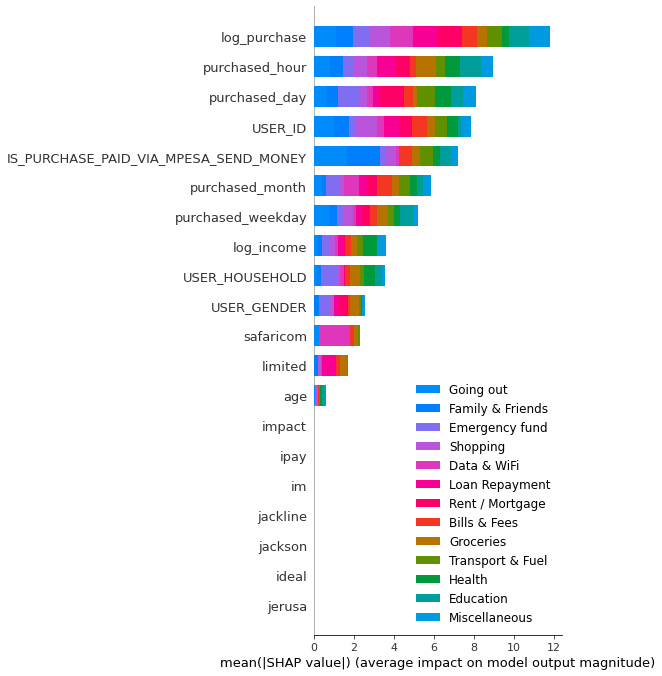

In [5]:
# histogram-based GBT
explain_models("71e0f0e65613406d88c6e63129f8b5e5", method="shap")

The least populated class in y has only 2 members, which is less than n_splits=5.


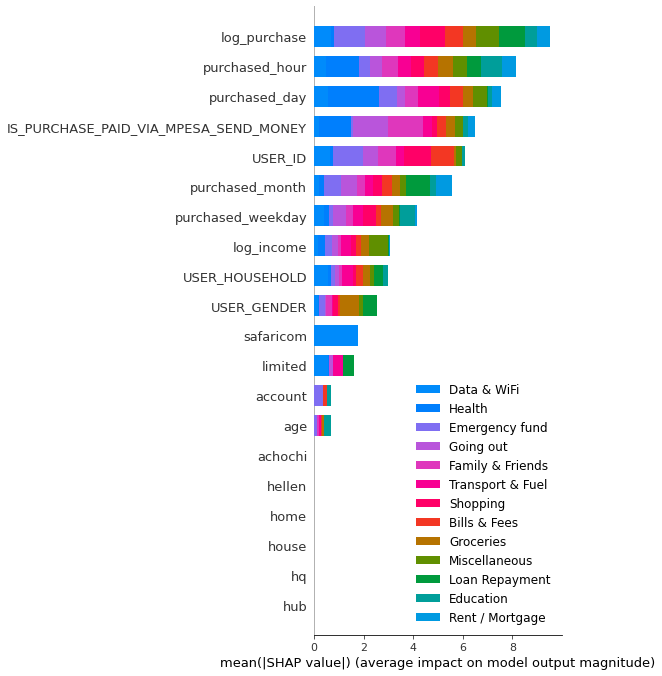

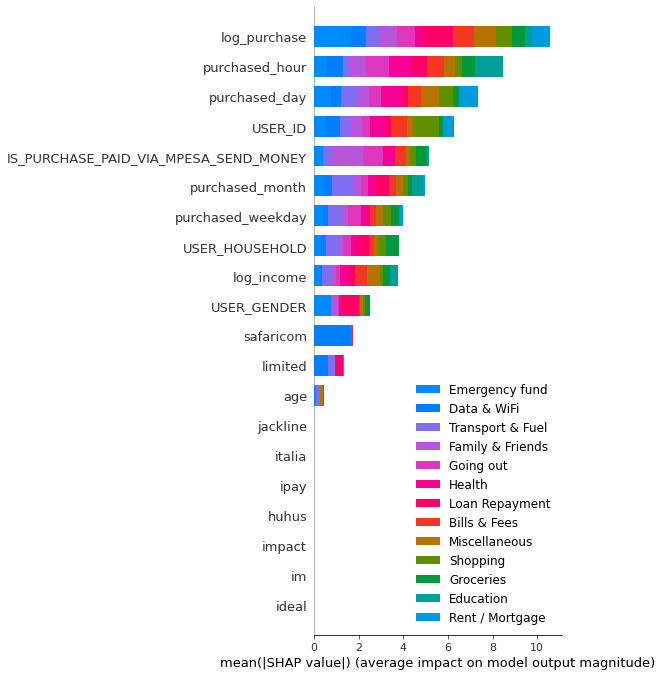

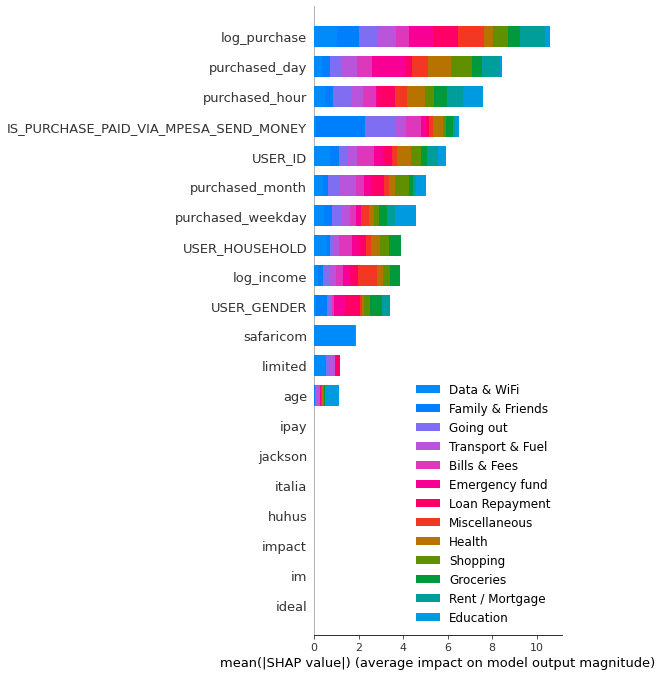

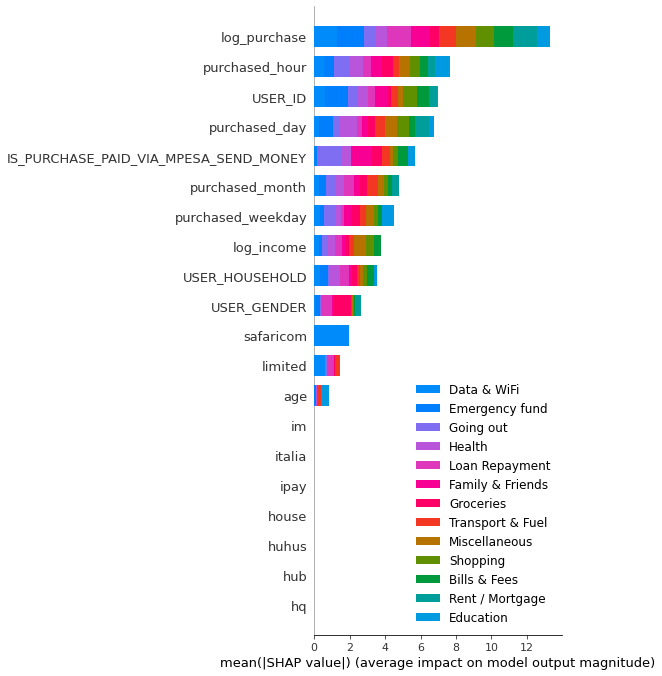

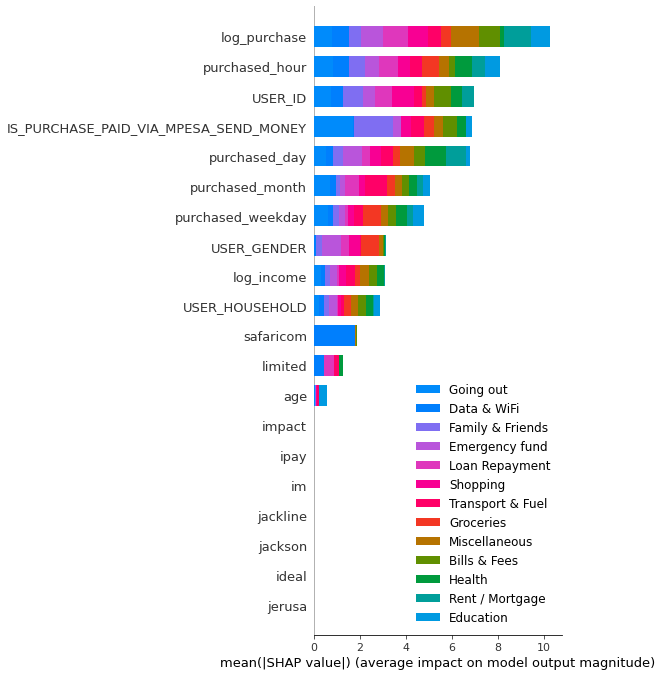

In [6]:
# LightGBM
explain_models("7caceff48db9434695cc7850f11347af", method="shap")

The least populated class in y has only 2 members, which is less than n_splits=5.


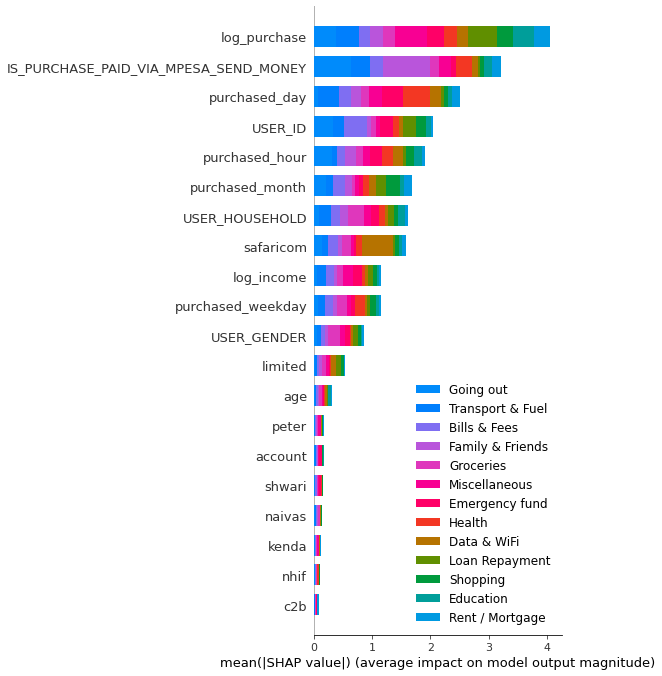

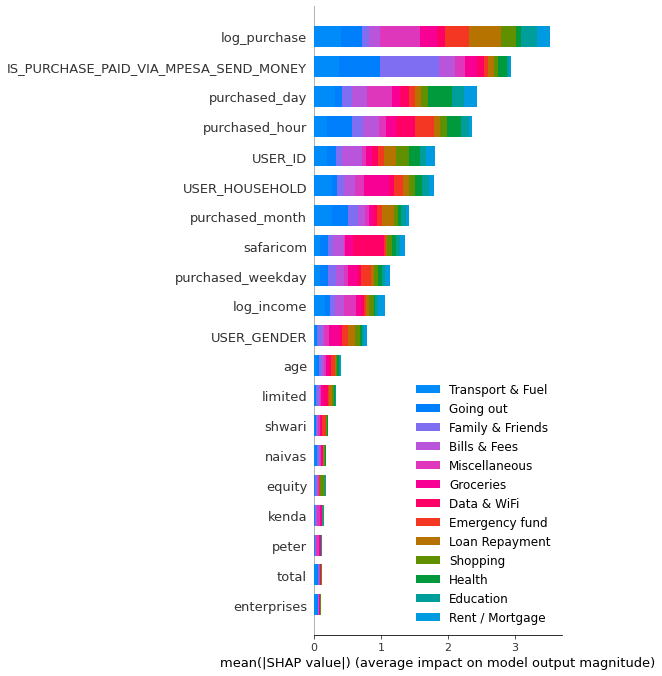

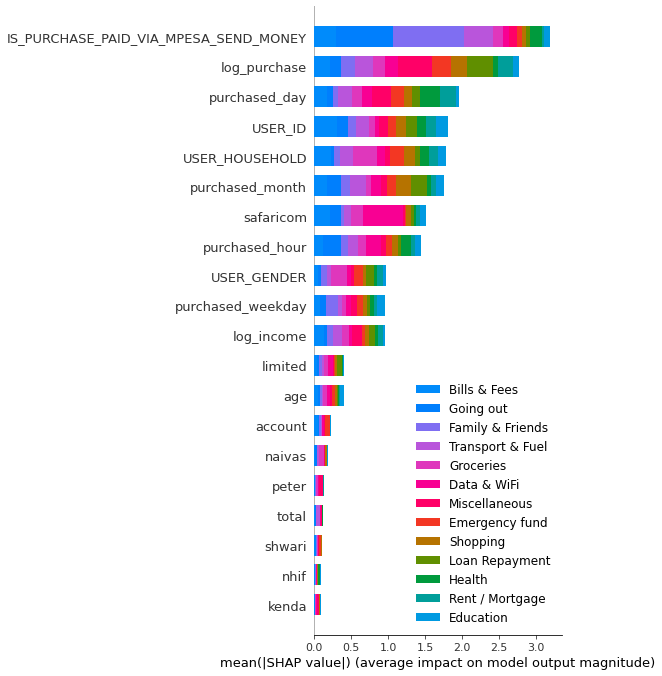

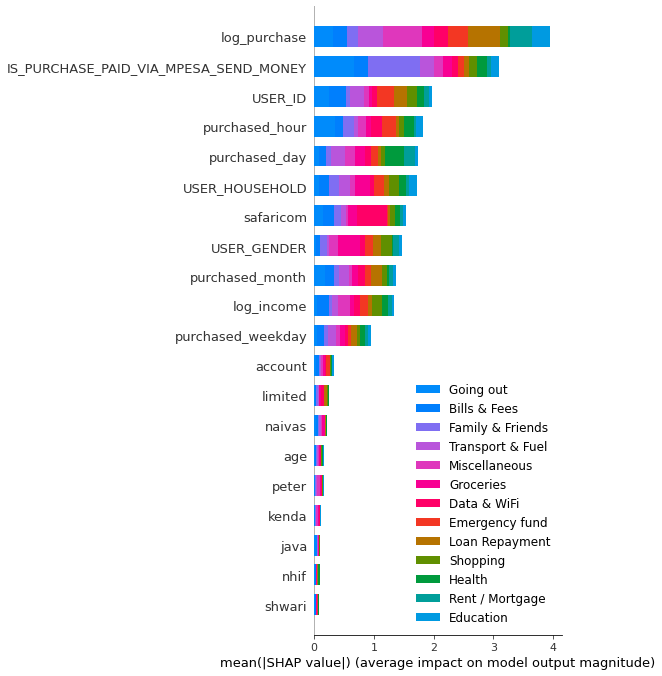

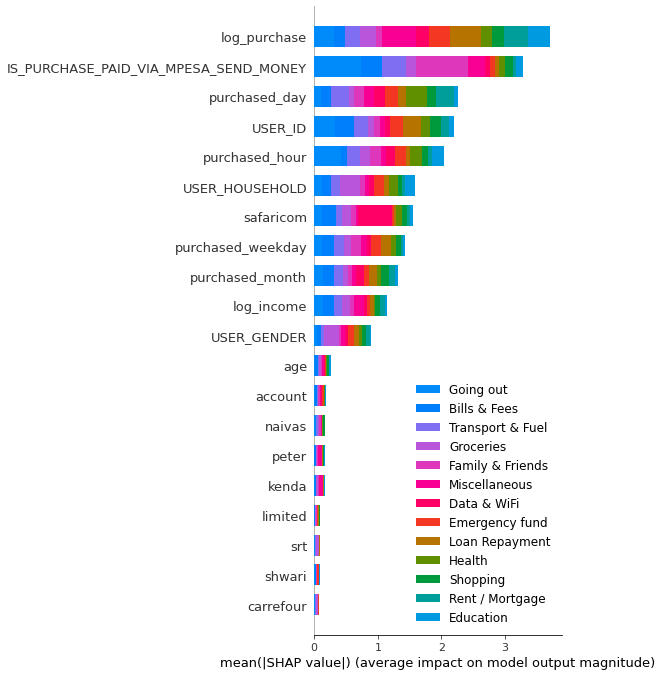

In [7]:
# CatBoost
explain_models("5a150d8abae84d87944a3c947a14f68b", method="shap")

The least populated class in y has only 2 members, which is less than n_splits=5.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


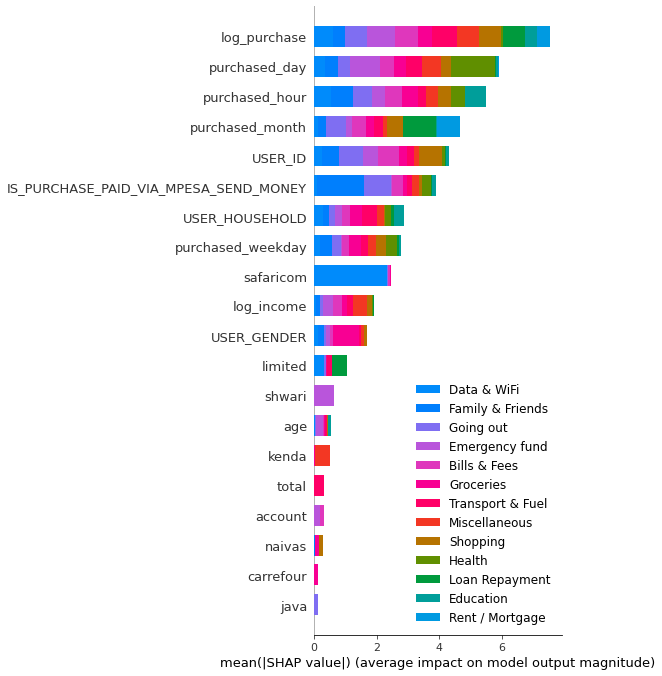

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


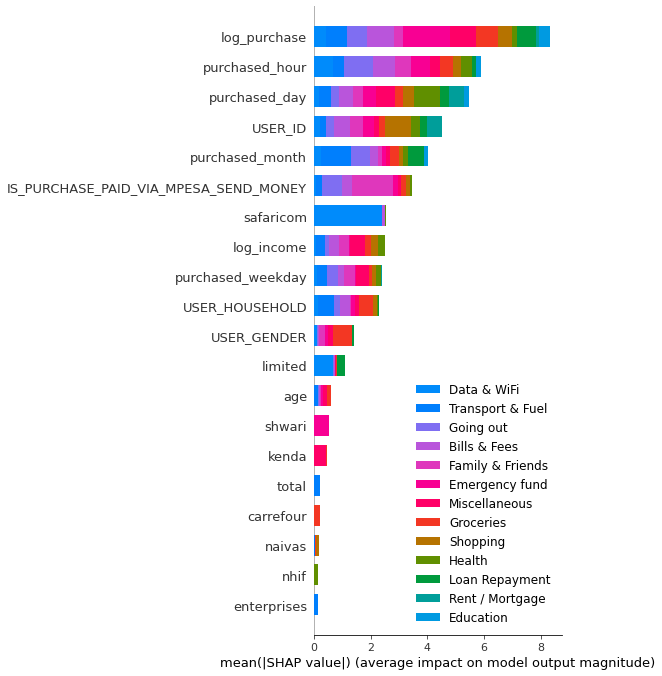

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


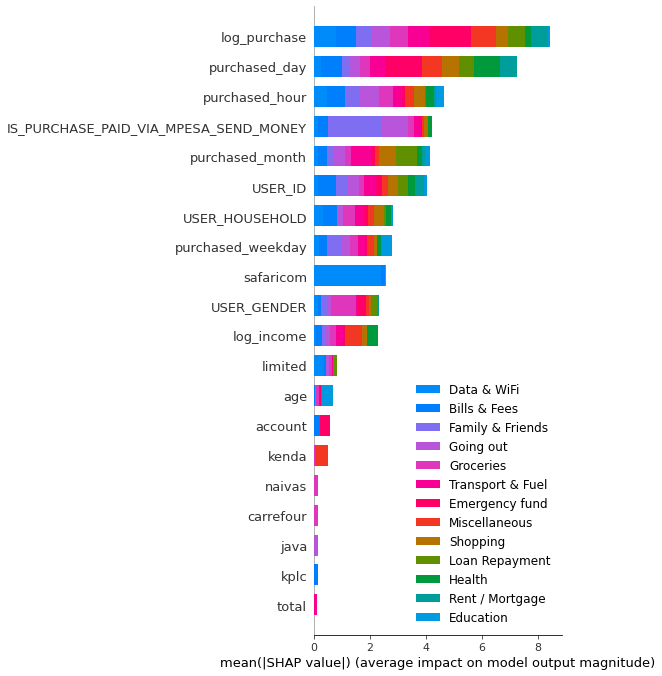

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


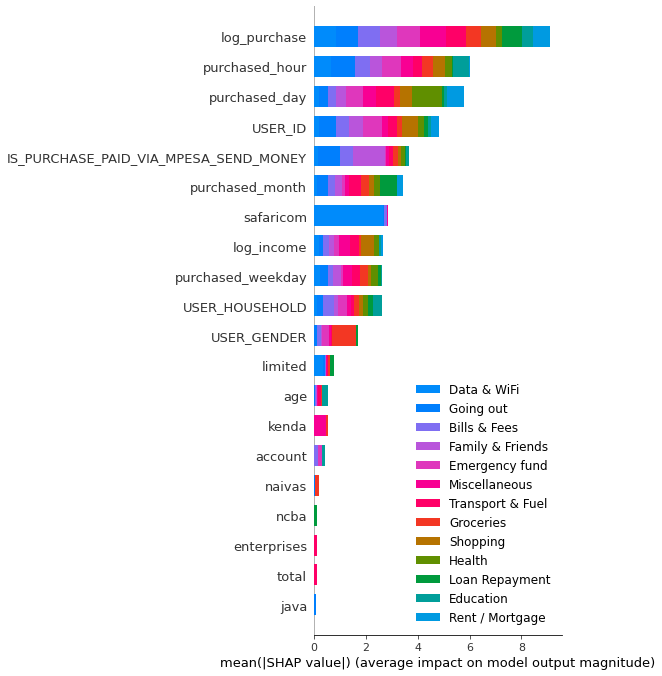

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


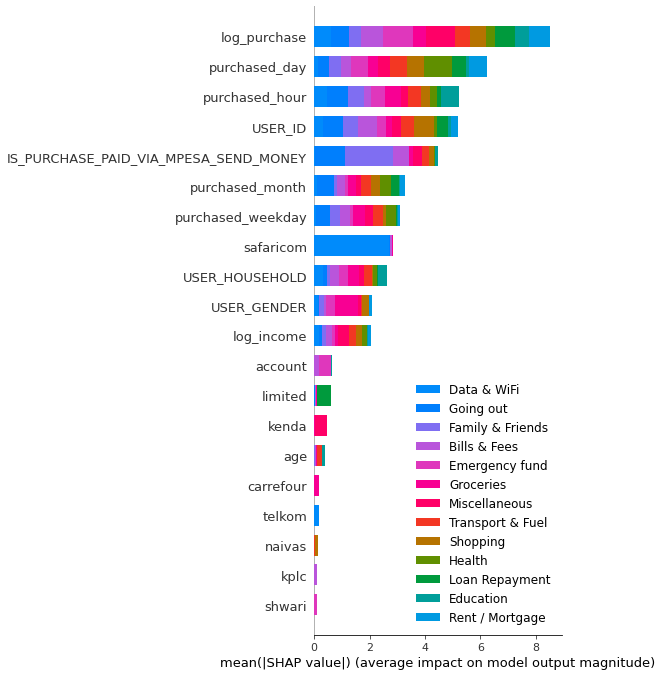

In [8]:
# XGBoost
explain_models("ce4da2287b8f424eb974adfe7fa46086", method="shap")